# Inventory & Replenishment Control — Solutions Notebook

This notebook mirrors the revised student notebook and adds **answers**
to each analytical question so you can see how a supply chain analyst might reason
from the code and the metrics.


## STEP 0 — Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(10,4)
df = pd.read_csv('https://raw.githubusercontent.com/saikisri97/17_Hof_Lecture_Code_Pingo/refs/heads/main/Supply_Chain_Analytics/data/inventory_replenishment_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,SKU,Demand,Receipt_Qty,On_Hand_Inventory,Backorder_Qty,On_Order_Qty,Lead_Time_Days
0,2024-01-01,SKU-INV-001,23,83.0,360.0,0.0,0.0,7
1,2024-01-02,SKU-INV-001,15,0.0,345.0,0.0,0.0,5
2,2024-01-03,SKU-INV-001,21,0.0,324.0,0.0,0.0,2
3,2024-01-04,SKU-INV-001,25,0.0,299.0,0.0,0.0,6
4,2024-01-05,SKU-INV-001,15,44.0,328.0,0.0,0.0,6


**Questions:**
- Identify which columns are **state variables** vs **flow variables**.
- Which columns would change if your replenishment policy changes?
- Which columns represent **real-world constraints** rather than decisions?

**Sample answer:**
- State variables describe the system *at a point in time*: `On_Hand_Inventory`, `On_Order_Qty`, `Backorder_Qty`.
- Flow variables describe movement *during* the period: `Demand`, `Receipt_Qty`.
- Replenishment policy mainly changes `On_Order_Qty` and indirectly `On_Hand_Inventory` and `Backorder_Qty` over time.
- `Lead_Time_Days` is largely a real-world constraint driven by suppliers and transport. Demand is also externally driven,
  though influenced by pricing and promotions.

## STEP 2 — KPI Computation

### 2A — Service Level

In [2]:
days_in_stock=(df['On_Hand_Inventory']>0).sum()
total_days=len(df)
service_level=days_in_stock/total_days*100
service_level

88.0

**Questions:**
- If service level improves by 3%, which **lines of code** or parameters upstream are likely to change?
- How would service level react if safety stock is increased? Predict direction, not exact value.

**Sample answer:**
- In code, `service_level` depends on `(df['On_Hand_Inventory']>0)`. To improve it by 3%, something must change
  upstream that reduces the number of zero-inventory days: higher order quantities, more frequent ordering,
  or shorter lead times. In a real system, that means changing reorder rules (ROP, review period) or safety stock.
- If safety stock increases and everything else stays constant, `On_Hand_Inventory` is less likely to hit zero,
  so service level will increase.

### 2B — Fill Rate

In [3]:
demand_served=(df['Demand']-df['Backorder_Qty']).clip(lower=0)
total_demand=df['Demand'].sum()
fill_rate=demand_served.sum()/total_demand*100
fill_rate

90.71994715984147

**Questions:**
- Which KPI is more sensitive to `Backorder_Qty`: Service Level or Fill Rate? Why?
- Suggest one code modification that could simulate a ‘partial fulfillment’ scenario. What would you change?

**Sample answer:**
- Fill Rate is directly sensitive to `Backorder_Qty` because `demand_served = Demand - Backorder_Qty`.
  Service Level only cares whether inventory was >0 on a given day; it does not know *how many* units were
  short. A day with partial fulfillment still counts as "in stock" for service level but reduces Fill Rate.
- To simulate partial fulfillment, you could artificially increase `Backorder_Qty` on certain days (e.g.,
  set it to 20% of Demand), or create a new column `Partial_Backorder_Qty` and compute `demand_served` from it
  instead. In code, you might write:
  `df['Backorder_Qty'] = df['Demand']*0.2` for a scenario test.

### 2C — Stockout %, Average Inventory, Turnover

In [4]:
stockout_days=(df['On_Hand_Inventory']==0).sum()
stockout_pct=stockout_days/total_days*100
avg_inventory=df['On_Hand_Inventory'].mean()
turnover=total_demand/avg_inventory
stockout_pct, avg_inventory, turnover

(12.0, 114.91333333333333, 26.350292974415503)

**Questions:**
- If turnover is very high, identify **two coding indicators** that might reveal why.
- How would you rewrite the code to segment turnover by month?
- Which KPI here would a controller (Finance) question first and why?

**Sample answer:**
- High turnover (`total_demand/avg_inventory`) can come from high `total_demand` or low `avg_inventory`.
  In code, you would inspect `df['Demand'].sum()` and `df['On_Hand_Inventory'].mean()` to see which side is extreme.
- To segment by month, you could create `df['Month']=df['Date'].dt.to_period('M')` and then compute
  `turnover_by_month = df.groupby('Month').apply(lambda g: g['Demand'].sum()/g['On_Hand_Inventory'].mean())`.
- A controller will especially look at `avg_inventory` and `turnover` because they drive working capital and
  balance-sheet exposure. Stockout % is operationally important but less directly visible on financial statements.

## STEP 3 — Descriptive Analytics

### 3A — Inventory Over Time

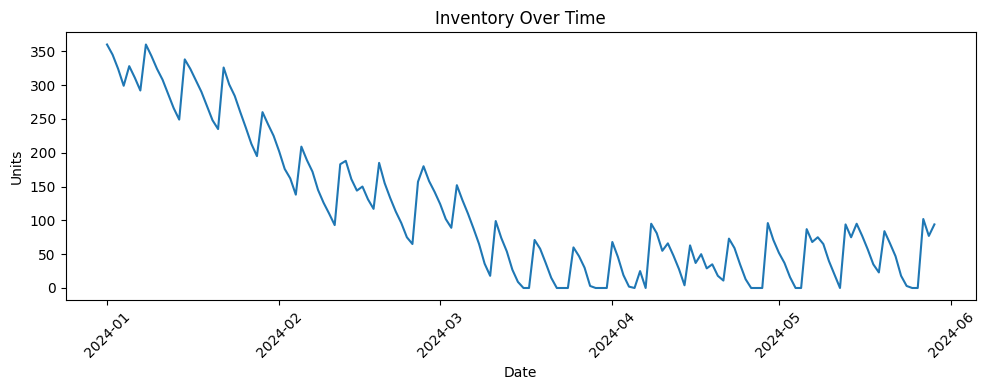

In [5]:
plt.plot(df['Date'],df['On_Hand_Inventory'])
plt.title('Inventory Over Time')
plt.xlabel('Date');plt.ylabel('Units')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Questions:**
- From the plot, identify any period where reorder timing was incorrect. Justify using data patterns.
- What modification to the code would add reorder point markers to the plot?
- If you were to identify a systematic delay, which metric in the dataset would you check next?

**Sample answer:**
- Incorrect reorder timing shows up as inventory repeatedly falling to zero or near-zero *before* the next
  replenishment arrives. Look for recurring sharp drops followed by late replenishment spikes.
- To add ROP markers, you could pre-compute a scalar `ROP` and then add a horizontal line:
  `plt.axhline(ROP, color='red', linestyle='--', label='ROP')`.
- To diagnose systematic delay, you would investigate `Lead_Time_Days` to see whether actual lead times are
  longer or more variable than assumed.

### 3B — Stockout Timeline

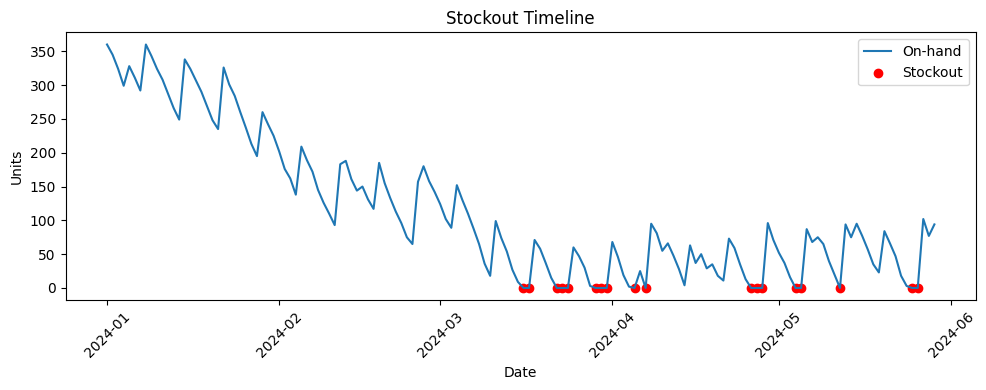

In [6]:
mask=df['On_Hand_Inventory']==0
plt.plot(df['Date'],df['On_Hand_Inventory'],label='On-hand')
plt.scatter(df.loc[mask,'Date'],df.loc[mask,'On_Hand_Inventory'],color='red',label='Stockout')
plt.title('Stockout Timeline')
plt.xlabel('Date');plt.ylabel('Units')
plt.legend();plt.xticks(rotation=45)
plt.tight_layout();plt.show()

**Questions:**
- Do stockouts align with predictable demand cycles or look random? Explain using evidence.
- Which additional column would you add in the dataset to better diagnose these stockouts?

**Sample answer:**
- If stockouts tend to occur at similar times (e.g., end of month, promotion periods), they likely align with
  predictable demand cycles. If they are scattered with no visible pattern, they might be due to ad-hoc issues
  or poor parameter settings.
- A useful additional column would be `Is_Promo` or `Season` to see if stockouts are driven by promotions/seasonality,
  or a `Supplier_ID` to see if certain suppliers systematically cause shortages.

### 3C — Demand vs Inventory

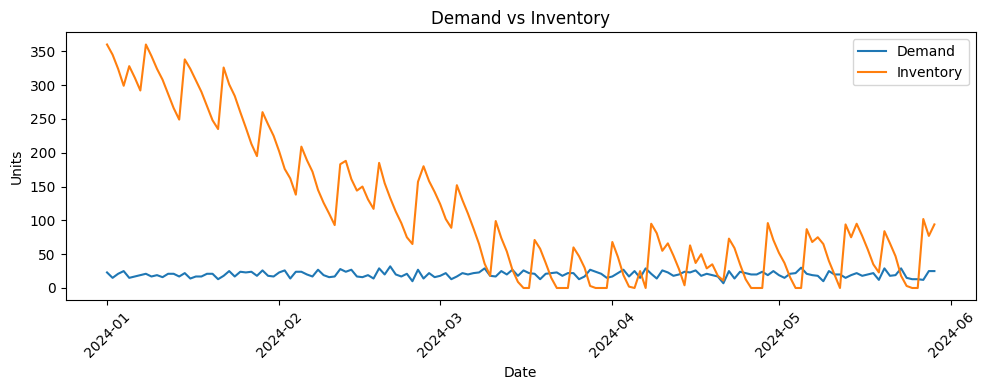

In [7]:
plt.plot(df['Date'],df['Demand'],label='Demand')
plt.plot(df['Date'],df['On_Hand_Inventory'],label='Inventory')
plt.legend();plt.xlabel('Date');plt.ylabel('Units')
plt.title('Demand vs Inventory')
plt.xticks(rotation=45)
plt.tight_layout();plt.show()

**Questions:**
- Identify any lag between demand peaks and inventory reactions. How would you detect lag programmatically?
- Suggest a code snippet to add a moving average of demand to stabilize interpretation.

**Sample answer:**
- Visual lag appears where demand spikes first and inventory only rises several days later. Programmatically,
  you could compute cross-correlation between demand and inventory or compare shifted series, e.g.,
  `df['Demand'].shift(3)` vs `On_Hand_Inventory`.
- To add a moving average of demand: `df['Demand_MA7']=df['Demand'].rolling(window=7).mean()` and then plot it
  alongside raw demand to smooth short-term noise.

## STEP 4 — Diagnostic Analytics

### 4A — Stockout Day Table

In [8]:
stockouts=df[df['On_Hand_Inventory']==0]
stockouts[['Date','Demand','Receipt_Qty','Lead_Time_Days']].head()

,Date,Demand,Receipt_Qty,Lead_Time_Days
75,2024-03-16,26,0.0,5
76,2024-03-17,22,0.0,3
81,2024-03-22,23,0.0,5
82,2024-03-23,18,0.0,6
83,2024-03-24,22,0.0,3


**Questions:**
- Determine whether stockouts are demand-driven or supply-driven using 2 indicators in the table.
- Suggest a new derived column that could help classify stockout causes more accurately.

**Sample answer:**
- If `Demand` on stockout days is well above its typical level while `Receipt_Qty` and `Lead_Time_Days` look normal,
  stockouts are likely demand-driven. If `Receipt_Qty` is zero/low and `Lead_Time_Days` is high relative to average,
  they are supply-driven.
- A helpful derived column could be `Demand_zscore = (Demand - avg_demand)/std_demand` or
  `LeadTime_deviation = Lead_Time_Days - avg_lead_time`, which makes classification rules more explicit.

### 4B — Cause Classification

In [9]:
avg_d=df['Demand'].mean();std_d=df['Demand'].std();avg_L=df['Lead_Time_Days'].mean()
def classify(r):
    ds=r['Demand']>avg_d+std_d
    late=r['Lead_Time_Days']>avg_L
    return 'Both' if ds and late else ('Demand Spike' if ds else 'Late Receipt' if late else 'Normal')
stockouts['Cause']=stockouts.apply(classify,axis=1)
stockouts['Cause'].value_counts()

/var/folders/y2/37476f0n7c793jplk1lghrkjr8cwhw/T/ipykernel_43622/1960189877.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stockouts['Cause']=stockouts.apply(classify,axis=1)


Cause
Normal          7
Late Receipt    7
Both            4
Name: count, dtype: int64

**Questions:**
- If ‘Both’ dominates, which operational teams must jointly intervene?
- How would you evolve the classification logic to include **supplier IDs** or **promotion flags**?

**Sample answer:**
- If 'Both' is frequent, both demand-planning teams (sales, marketing, S&OP) and supply teams (procurement,
  logistics, suppliers) must collaborate. The issue is not purely on one side.
- To include `Supplier_ID`, you might add a rule such as: if certain suppliers repeatedly have long lead times,
  classify as 'Structural Supply Risk'. With `Is_Promo`, you might flag stockouts during promotions separately,
  e.g., 'Promo Demand Spike', by checking `Is_Promo==1` in the classification function.

## STEP 5 — Predictive Analytics

### 5A — Days-to-Stockout

In [10]:
latest=df.iloc[-1]
current=latest['On_Hand_Inventory']
recent_avg=df['Demand'].tail(14).mean()
days_to_zero=current/recent_avg if recent_avg>0 else np.inf
days_to_zero

4.874074074074074

**Questions:**
- Is the run-rate method stable? What alternative calculation could you propose using rolling windows?
- Suggest one improvement to reduce noise in the prediction.

**Sample answer:**
- The run-rate method uses only the recent average demand, so it can be unstable if demand is highly volatile.
  An alternative is to use a rolling average over a longer window (e.g., 28 days) or a weighted average giving
  more weight to recent days but not ignoring older data.
- To reduce noise, you could cap extreme demand days (winsorization), use median instead of mean, or segment
  demand by season before computing the run-rate.

### 5B — 10-Day Projection

In [11]:
sim=[];x=current
for i in range(10):
    x=max(x-recent_avg,0)
    sim.append(x)
proj_df=pd.DataFrame({'Day':range(1,11),'Projected_On_Hand':sim})
proj_df

,Day,Projected_On_Hand
0,1,74.714286
1,2,55.428571
2,3,36.142857
3,4,16.857143
4,5,0.000000
5,6,0.000000
6,7,0.000000
7,8,0.000000
8,9,0.000000
9,10,0.000000


**Questions:**
- On which day do you hit zero? How does this compare to supplier lead time?
- How would you modify code to simulate a demand spike on Day 4?

**Sample answer:**
- The day where `Projected_On_Hand` first becomes zero is the projected stockout day under a constant-demand
  assumption. Comparing this to average `Lead_Time_Days` tells you whether you will run out before or after
  the next replenishment can realistically arrive.
- To simulate a demand spike on Day 4, you could reduce inventory more on that iteration, e.g.:
  `for i in range(10): demand = recent_avg*1.5 if i==3 else recent_avg; x=max(x-demand,0)`.
  This lets you see the sensitivity of stockout timing to an isolated spike.

## STEP 6 — Prescriptive Decision

### 6A — Safety Stock & ROP

In [12]:
D_avg=df['Demand'].mean();sigma=df['Demand'].std();L=df['Lead_Time_Days'].mean();z=1.65
SS=z*sigma*np.sqrt(L);ROP=D_avg*L+SS
SS,ROP

(16.105652517259628, 107.34938585059295)

**Questions:**
- If SS increases by 20%, which KPI changes first and why?
- Suggest a coding approach to simulate different service level targets by changing `z` dynamically.

**Sample answer:**
- Increasing SS raises the reorder point and typically increases average inventory. The most immediate KPI
  that changes is **Average Inventory**, which in turn affects **Inventory Turnover** and reduces **Stockout %**.
- To simulate different service level targets, you can loop over a list of `z` values (e.g., [1.28, 1.65, 2.05])
  and recompute `SS` and `ROP` for each, storing results in a DataFrame. For example:
  `for z in z_list: SS=z*sigma*np.sqrt(L); ROP=D_avg*L+SS`.

### 6B — Order Quantity

In [13]:
on_hand=latest['On_Hand_Inventory'];on_order=latest['On_Order_Qty'];review=7
current_pos=on_hand+on_order
order_qty=max(D_avg*(L+review)+SS-current_pos,0)
order_qty

0

**Questions:**
- Does the recommended order quantity align with practical truck/pallet constraints?
- If you were to integrate MOQ or EOQ logic, what additional parameters would you include?

**Sample answer:**
- In practice, orders are placed in pallet, carton, or truckload multiples. If the calculated `order_qty`
  is not aligned with these pack sizes, you would round it up or down accordingly, possibly trading off
  efficiency vs. service.
- To integrate MOQ/EOQ, you would include parameters like fixed order cost, holding cost per unit per period,
  and supplier-defined minimum order quantities. The final order quantity would then be `max(calculated_qty, MOQ, EOQ)`
  adjusted to logistics constraints.

### 6C — Managerial Summary

**Example summary:**
- KPIs show the balance between service (Service Level, Fill Rate) and efficiency (Avg Inventory, Turnover).
- Diagnostic analysis reveals whether stockouts are mainly demand-driven, supply-driven, or both.
- Predictive analysis (run-rate days-to-stockout and 10-day projection) highlights risk windows where cover is low
  relative to lead time.
- Prescriptive metrics (SS, ROP, order quantity) translate variability and lead time into actionable ordering rules.
- A good replenishment policy aligns these analytics with practical constraints such as truck sizes, MOQs, and cash limits.